# Advanced Deep Learning (D7047E) - Project

**Car Detection in Snow**

Source: https://nvd.ltu-ai.dev/

## Installing required packages

In [2]:
%%capture

!pip install ultralytics

## Imports

In [3]:
import os, yaml, random

from zipfile import ZipFile
from ultralytics import YOLO
from IPython.display import Image

## Preprocessing

### Dataset Download

In [4]:
!wget -nc "https://filedn.eu/lwnF6OGJjyNyTUCGJUbsnVp/public_data/project_nvd/Labeled%20Frames%20(YOLO%20Format).zip" -O data.zip

--2024-05-15 16:20:55--  https://filedn.eu/lwnF6OGJjyNyTUCGJUbsnVp/public_data/project_nvd/Labeled%20Frames%20(YOLO%20Format).zip
Resolving filedn.eu (filedn.eu)... 45.131.244.47
Connecting to filedn.eu (filedn.eu)|45.131.244.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25716186975 (24G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  23.95G  37.5MB/s    in 10m 13s 

2024-05-15 16:31:09 (40.0 MB/s) - ‘data.zip’ saved [25716186975/25716186975]



### Unzipping & Removing unnecessary files

In [5]:
with ZipFile("data.zip", 'r') as f:
    f.extractall("data")

os.remove("data.zip")
os.remove("data/train.txt")
os.remove("data/val.txt")
os.remove("data/test.txt")

### Split into train/validation/test

In [6]:
dataset_splits = ["train", "val", "test"]
splits_ranges = [(0, 0.6), (0.6, 0.8), (0.8, 1)]

file_names = [name for name in os.listdir('data/images')]
no_files = len(file_names)

files_indexes = list(range(no_files))

random.seed(45)
random.shuffle(files_indexes)

files_ranges_by_split = [
    (int(start_idx * no_files), int(end_idx * no_files))
    for start_idx, end_idx in splits_ranges
]

files_indexes_by_split = {
    key: files_indexes[start_idx:end_idx]
    for key, (start_idx, end_idx) in zip(dataset_splits, files_ranges_by_split)
}

for split in dataset_splits:
    os.mkdir(f"data/{split}")
    os.mkdir(f"data/{split}/images")
    os.mkdir(f"data/{split}/labels")

    for file_index in files_indexes_by_split[split]:
        img_file_name = file_names[file_index]
        label_file_name = img_file_name.replace(".png", ".txt")

        os.rename(
            f"data/images/{img_file_name}",
            f"data/{split}/images/{img_file_name}"
        )

        os.rename(
            f"data/labels/{label_file_name}",
            f"data/{split}/labels/{label_file_name}"
        )

os.rmdir("data/images")
os.rmdir("data/labels")

### Build YAML file for dataset

In [7]:
WORKING_DIR = '/content'

dataset_info = {
    'train': f'{WORKING_DIR}/data/train',
    'val': f'{WORKING_DIR}/data/val',
    'test': f'{WORKING_DIR}/data/test',
    'nc': 1,
    'names': ['Car']
}

with open(f'{WORKING_DIR}/data.yaml', 'w') as f:
    yaml.dump(dataset_info, f)

## Visualisation

Example frame name

In [8]:
visualisation_file_name = "2022-12-02 Asjo 01_stabilized-frame0683"

### Drone image of cars

The image is not annotated, but two cars can be spotted.

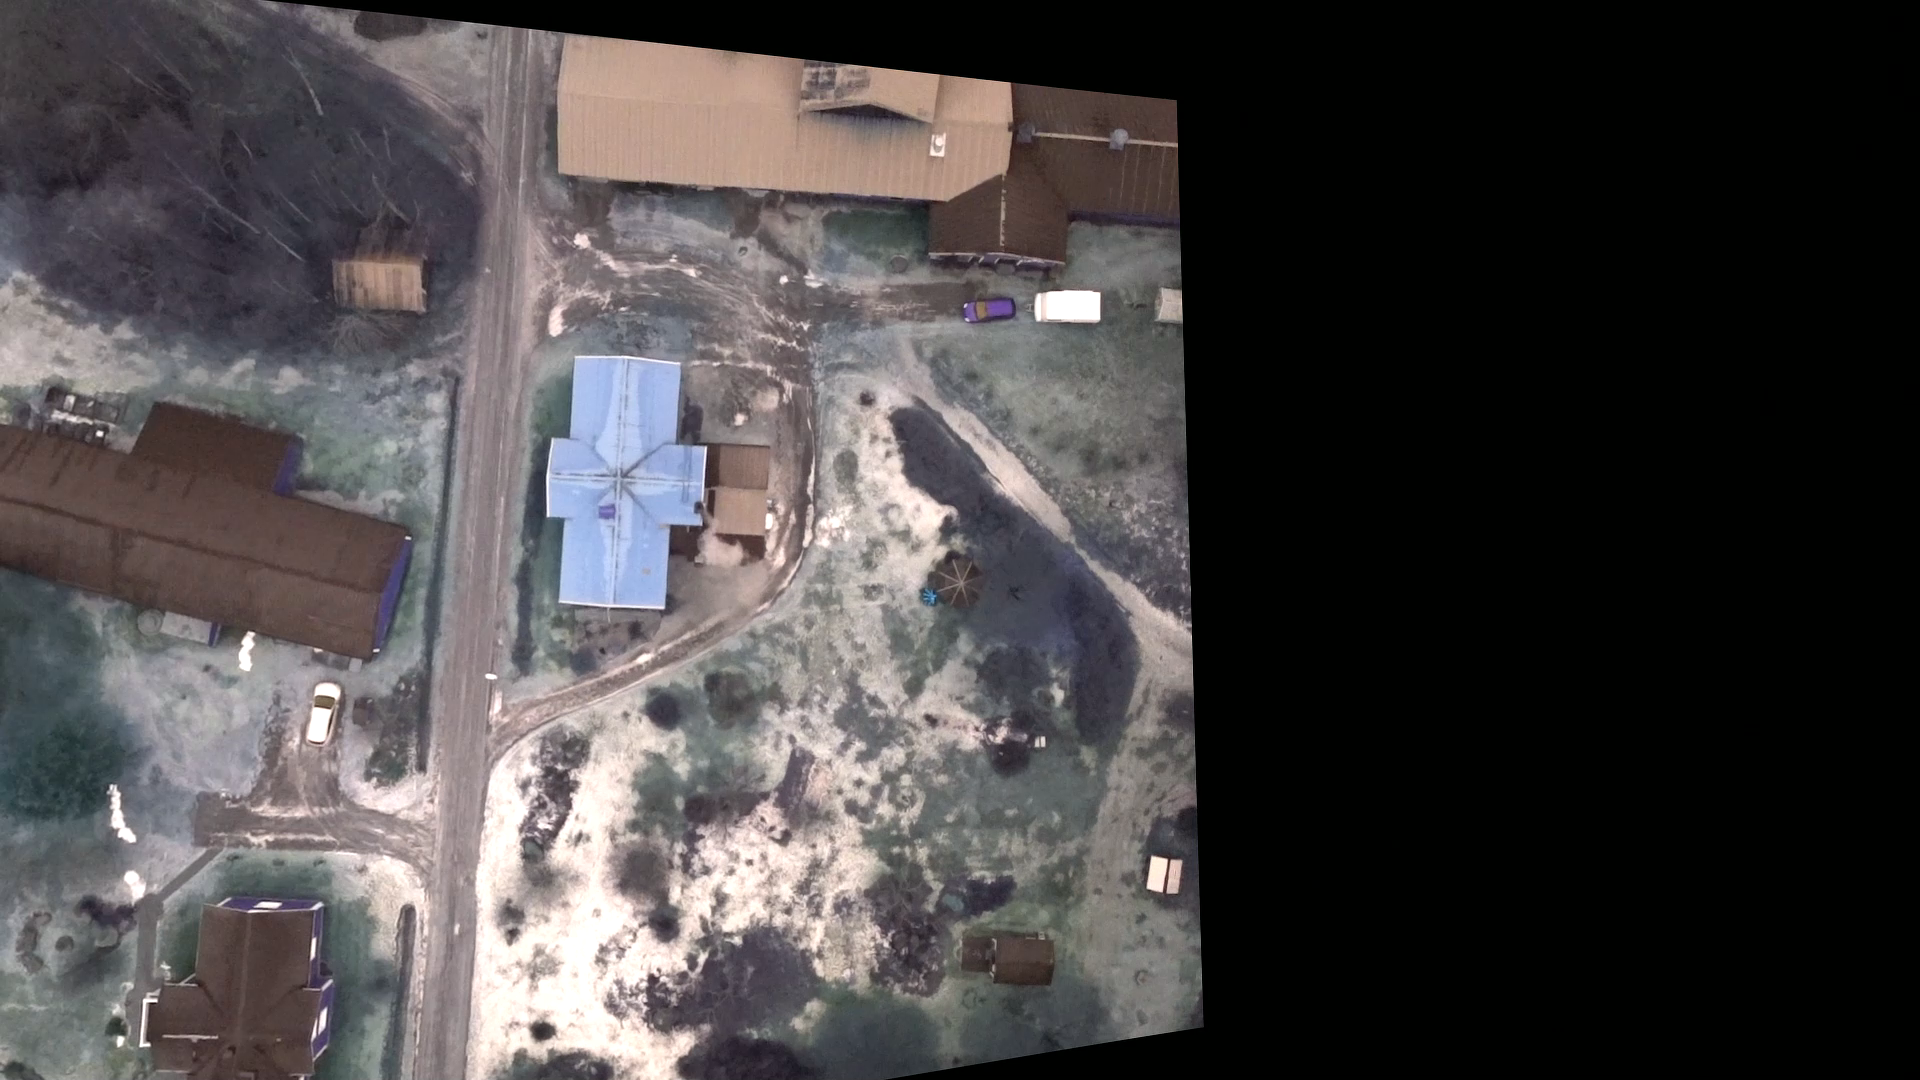

In [9]:
Image(filename=f"data/train/images/{visualisation_file_name}.png")

### Labels

Label format: `0 cx cy w h`

- `0` shows the label (`0` being a car)
- `cx` shows the x position of the car in the [0, 1] range (car's left corner)
- `cy` shows the y position of the car in the [0, 1] range (car's left corner)
- `w` shows the width of the car in the [0, 1] range (1 means full width)
- `h` shows the height of the car in the [0, 1] range (1 means full height)

In [10]:
with open(f"data/train/labels/{visualisation_file_name}.txt", "r") as f:
    labels = f.read()

print(labels.strip())

0 0.16837 0.66212 0.03136 0.08364
0 0.51463 0.28708 0.03582 0.03933


## Training

In [4]:
# Initialize network with pre-trained weights
model = YOLO('yolov9c.pt')

# Train model
train_results = model.train(data='data.yaml', epochs=20)

New https://pypi.org/project/ultralytics/8.2.16 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.15 🚀 Python-3.11.0rc1 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

train: Scanning /datasets/data/train/labels.cache... 5070 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5070/5070 [00:00<?, ?it/s]
val: Scanning /datasets/data/val/labels.cache... 1690 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1690/1690 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      10.9G      1.887      1.931     0.9339         78        640: 100%|██████████| 317/317 [02:02<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.41it/s]


                   all       1690       5190     0.0249       0.65      0.021    0.00899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20        11G      1.772      1.156     0.8971         80        640: 100%|██████████| 317/317 [01:57<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.67it/s]


                   all       1690       5190      0.654      0.524      0.573      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20        11G      1.616      1.005     0.8754         97        640: 100%|██████████| 317/317 [01:56<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.48it/s]


                   all       1690       5190      0.776      0.705       0.78      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20        11G      1.517     0.8999     0.8595         68        640: 100%|██████████| 317/317 [01:54<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.66it/s]


                   all       1690       5190      0.728      0.786      0.698       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      11.1G      1.402     0.8141     0.8471         53        640: 100%|██████████| 317/317 [01:54<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.67it/s]


                   all       1690       5190      0.792      0.652      0.732       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20        11G      1.331     0.7334     0.8391         65        640: 100%|██████████| 317/317 [01:54<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.65it/s]


                   all       1690       5190      0.887      0.881      0.895       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.8G      1.265     0.6941     0.8311         91        640: 100%|██████████| 317/317 [01:54<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.66it/s]


                   all       1690       5190      0.893      0.815      0.886      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.8G      1.204     0.6504     0.8242         94        640: 100%|██████████| 317/317 [01:54<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.67it/s]


                   all       1690       5190       0.91      0.831      0.913       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20        11G       1.18     0.6209     0.8241         42        640: 100%|██████████| 317/317 [01:54<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.66it/s]


                   all       1690       5190       0.92      0.856      0.931      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20        11G      1.106     0.5804     0.8182         66        640: 100%|██████████| 317/317 [01:54<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.69it/s]


                   all       1690       5190       0.91      0.845      0.924      0.525
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20        11G      1.058     0.5617     0.8168         33        640: 100%|██████████| 317/317 [01:56<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.69it/s]


                   all       1690       5190      0.914      0.854      0.931       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20        11G      1.038     0.5521     0.8159         50        640: 100%|██████████| 317/317 [01:54<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.63it/s]


                   all       1690       5190      0.925      0.885      0.946      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20        11G     0.9971     0.5236     0.8111         30        640: 100%|██████████| 317/317 [01:53<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.70it/s]


                   all       1690       5190      0.944      0.897      0.955      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G     0.9593     0.5011     0.8058         39        640: 100%|██████████| 317/317 [01:53<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]


                   all       1690       5190      0.938      0.916      0.964      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20        11G     0.9193     0.4757      0.801         45        640: 100%|██████████| 317/317 [01:53<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]


                   all       1690       5190      0.941      0.922      0.957      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.8G     0.8796     0.4544     0.8008         30        640: 100%|██████████| 317/317 [01:53<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]

                   all       1690       5190      0.966      0.931      0.977      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20        11G     0.8418     0.4301     0.7971         42        640: 100%|██████████| 317/317 [01:53<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]


                   all       1690       5190      0.957      0.909      0.968      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20        11G     0.8118     0.4167     0.7937         24        640: 100%|██████████| 317/317 [01:53<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]


                   all       1690       5190      0.958      0.928      0.975      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20        11G     0.7686     0.3935     0.7937         52        640: 100%|██████████| 317/317 [01:53<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]

                   all       1690       5190      0.956      0.943      0.976      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20        11G     0.7356     0.3778     0.7905         42        640: 100%|██████████| 317/317 [01:53<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]

                   all       1690       5190      0.967      0.937      0.981      0.744



20 epochs completed in 0.715 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.15 🚀 Python-3.11.0rc1 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
YOLOv9c summary (fused): 384 layers, 25320019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.29it/s]


                   all       1690       5190      0.967      0.938      0.981      0.744
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


## Validation

In [5]:
# Run model with best training weights
model = YOLO('runs/detect/train/weights/best.pt')

val_results = model.val()

Ultralytics YOLOv8.2.15 🚀 Python-3.11.0rc1 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
YOLOv9c summary (fused): 384 layers, 25320019 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /datasets/data/val/labels.cache... 1690 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1690/1690 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [00:19<00:00,  5.49it/s]


                   all       1690       5190      0.966      0.939      0.981       0.75
Speed: 0.1ms preprocess, 7.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val


## Test

In [6]:
# Run model with best training weights
model = YOLO('runs/detect/train/weights/best.pt')

test_results = model.val(split='test')

Ultralytics YOLOv8.2.15 🚀 Python-3.11.0rc1 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
YOLOv9c summary (fused): 384 layers, 25320019 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /datasets/data/test/labels.cache... 1690 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1690/1690 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [00:20<00:00,  5.18it/s]


                   all       1690       5287      0.972      0.947      0.983      0.763
Speed: 0.1ms preprocess, 6.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val2


## Results

### Losses & Metrics Evolution over Training Phase

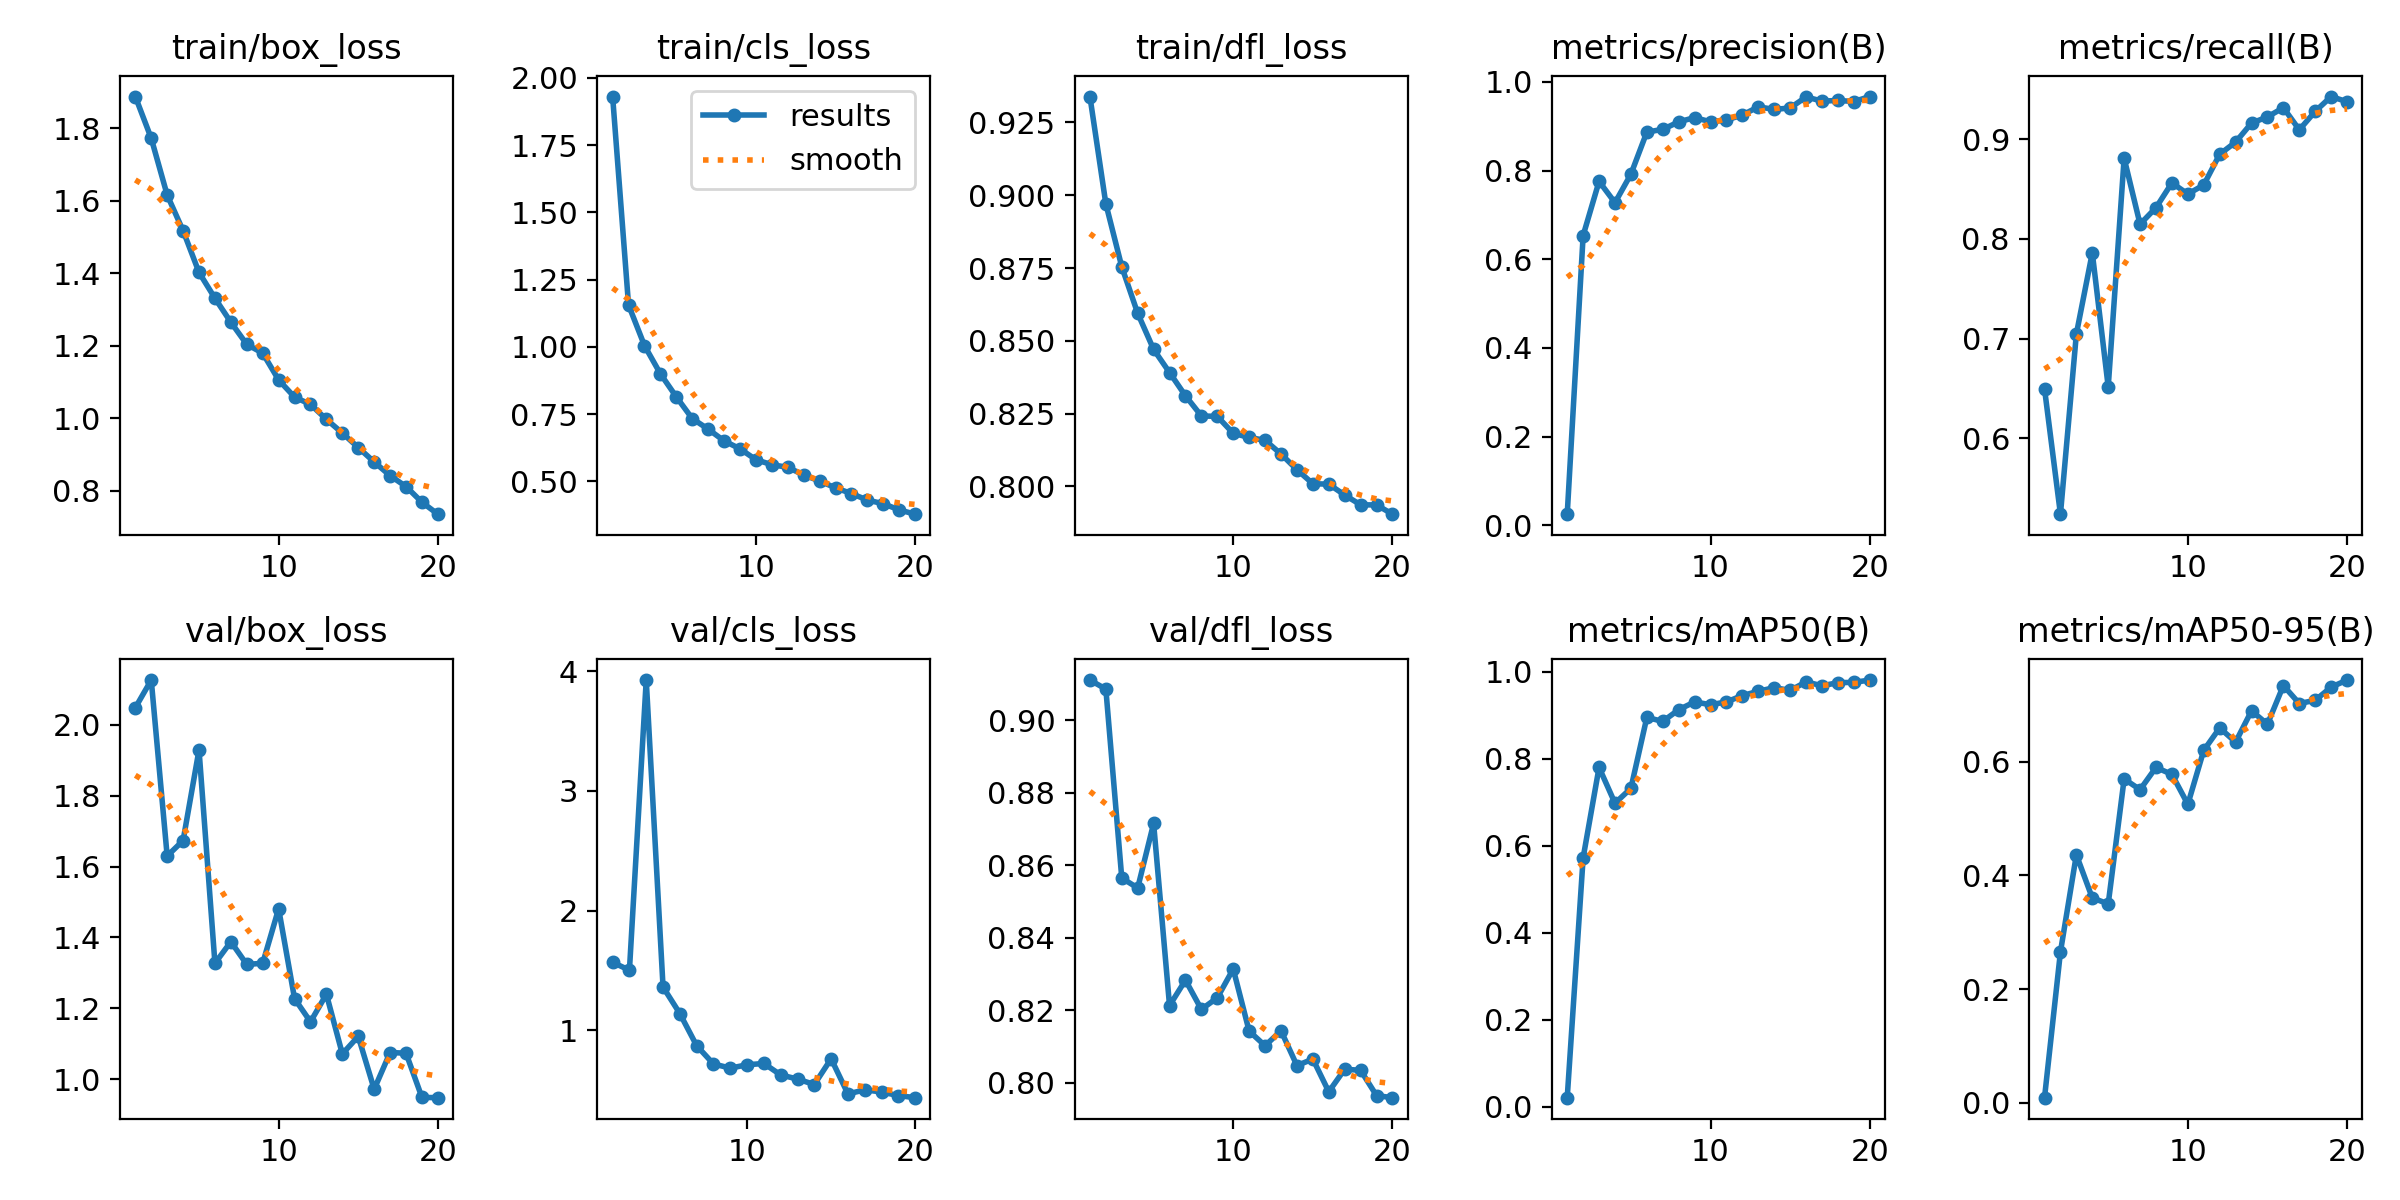

In [7]:
Image(filename=f"runs/detect/train/results.png")

### Metrics

In [8]:
def print_metrics(results):
    p, r, map50, map5095 = results

    print(f"Precision: {round(p * 100, 2)}%")
    print(f"Recall: {round(r * 100, 2)}%")
    print(f"mAP50: {round(map50 * 100, 2)}%")
    print(f"mAP50-95: {round(map5095 * 100, 2)}%")

print("---Train Metrics---\n")
print_metrics(train_results.mean_results())

print("\n---Validation Metrics---\n")
print_metrics(val_results.mean_results())

print("\n---Test Metrics---\n")
print_metrics(test_results.mean_results())

---Train Metrics---

Precision: 96.66%
Recall: 93.8%
mAP50: 98.1%
mAP50-95: 74.38%

---Validation Metrics---

Precision: 96.59%
Recall: 93.9%
mAP50: 98.12%
mAP50-95: 74.98%

---Test Metrics---

Precision: 97.21%
Recall: 94.72%
mAP50: 98.34%
mAP50-95: 76.3%


### Confusion Matrix

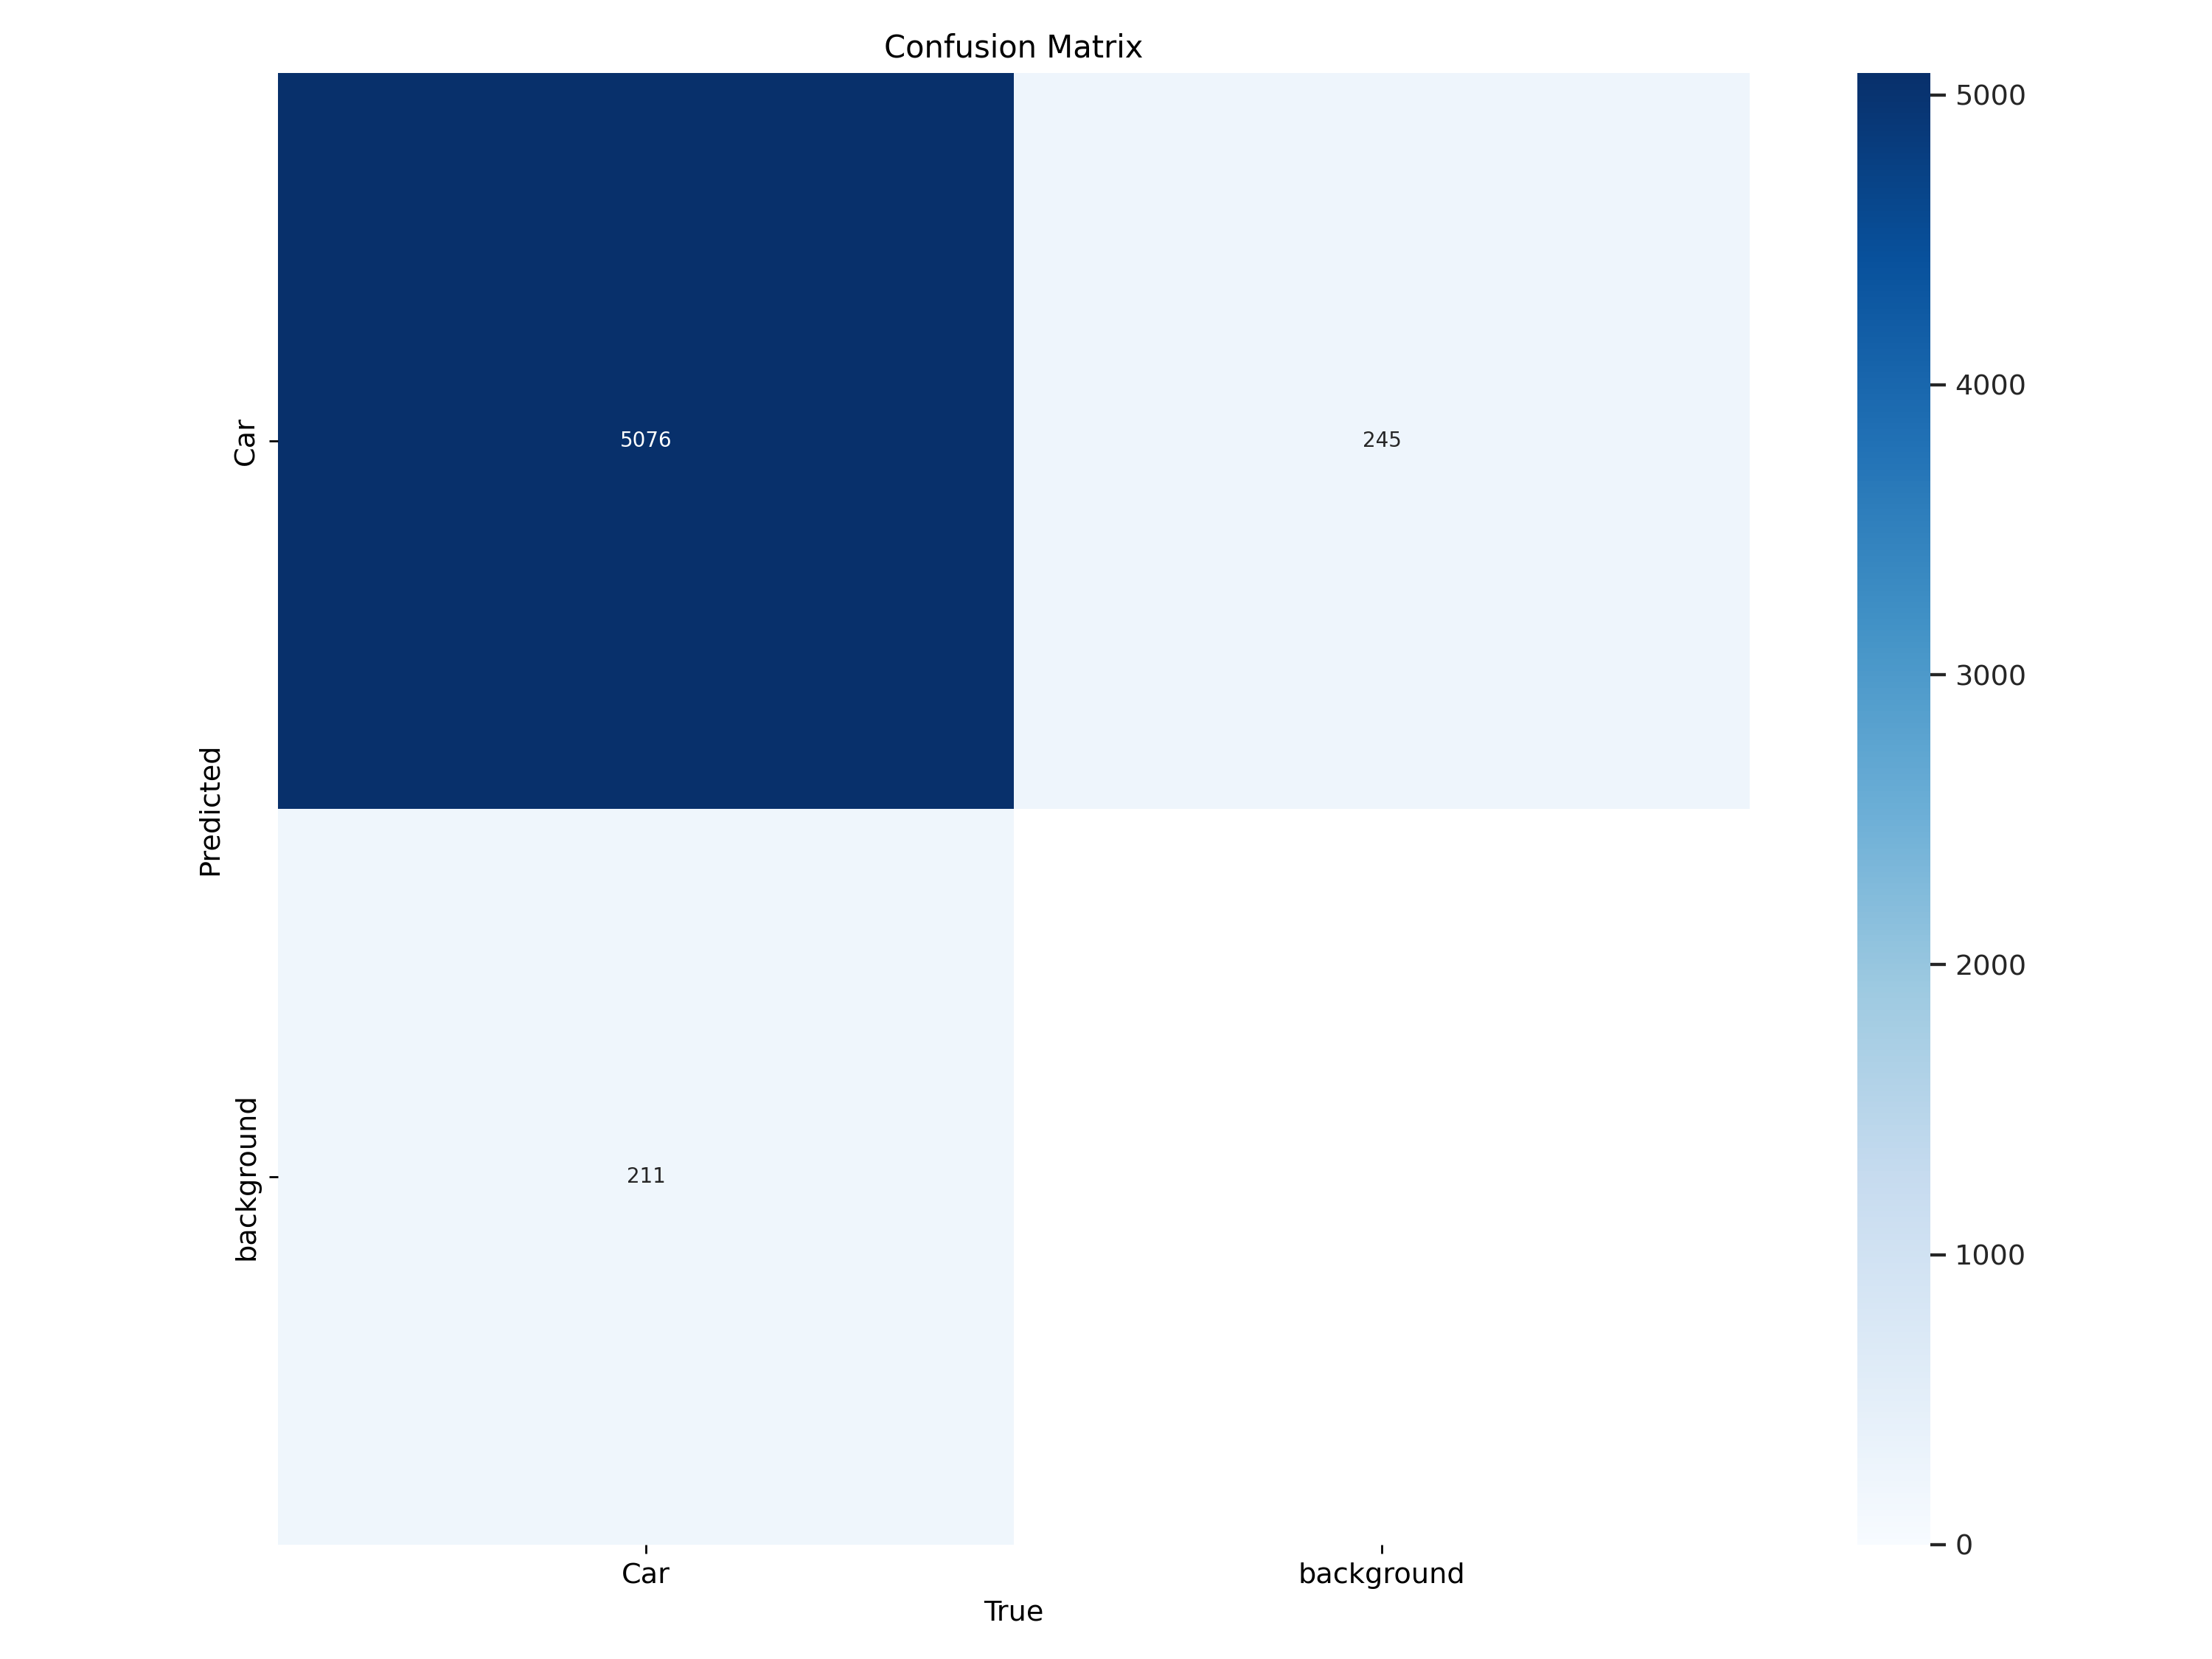

In [9]:
Image(filename=f"runs/detect/val2/confusion_matrix.png")

### Prediction Example

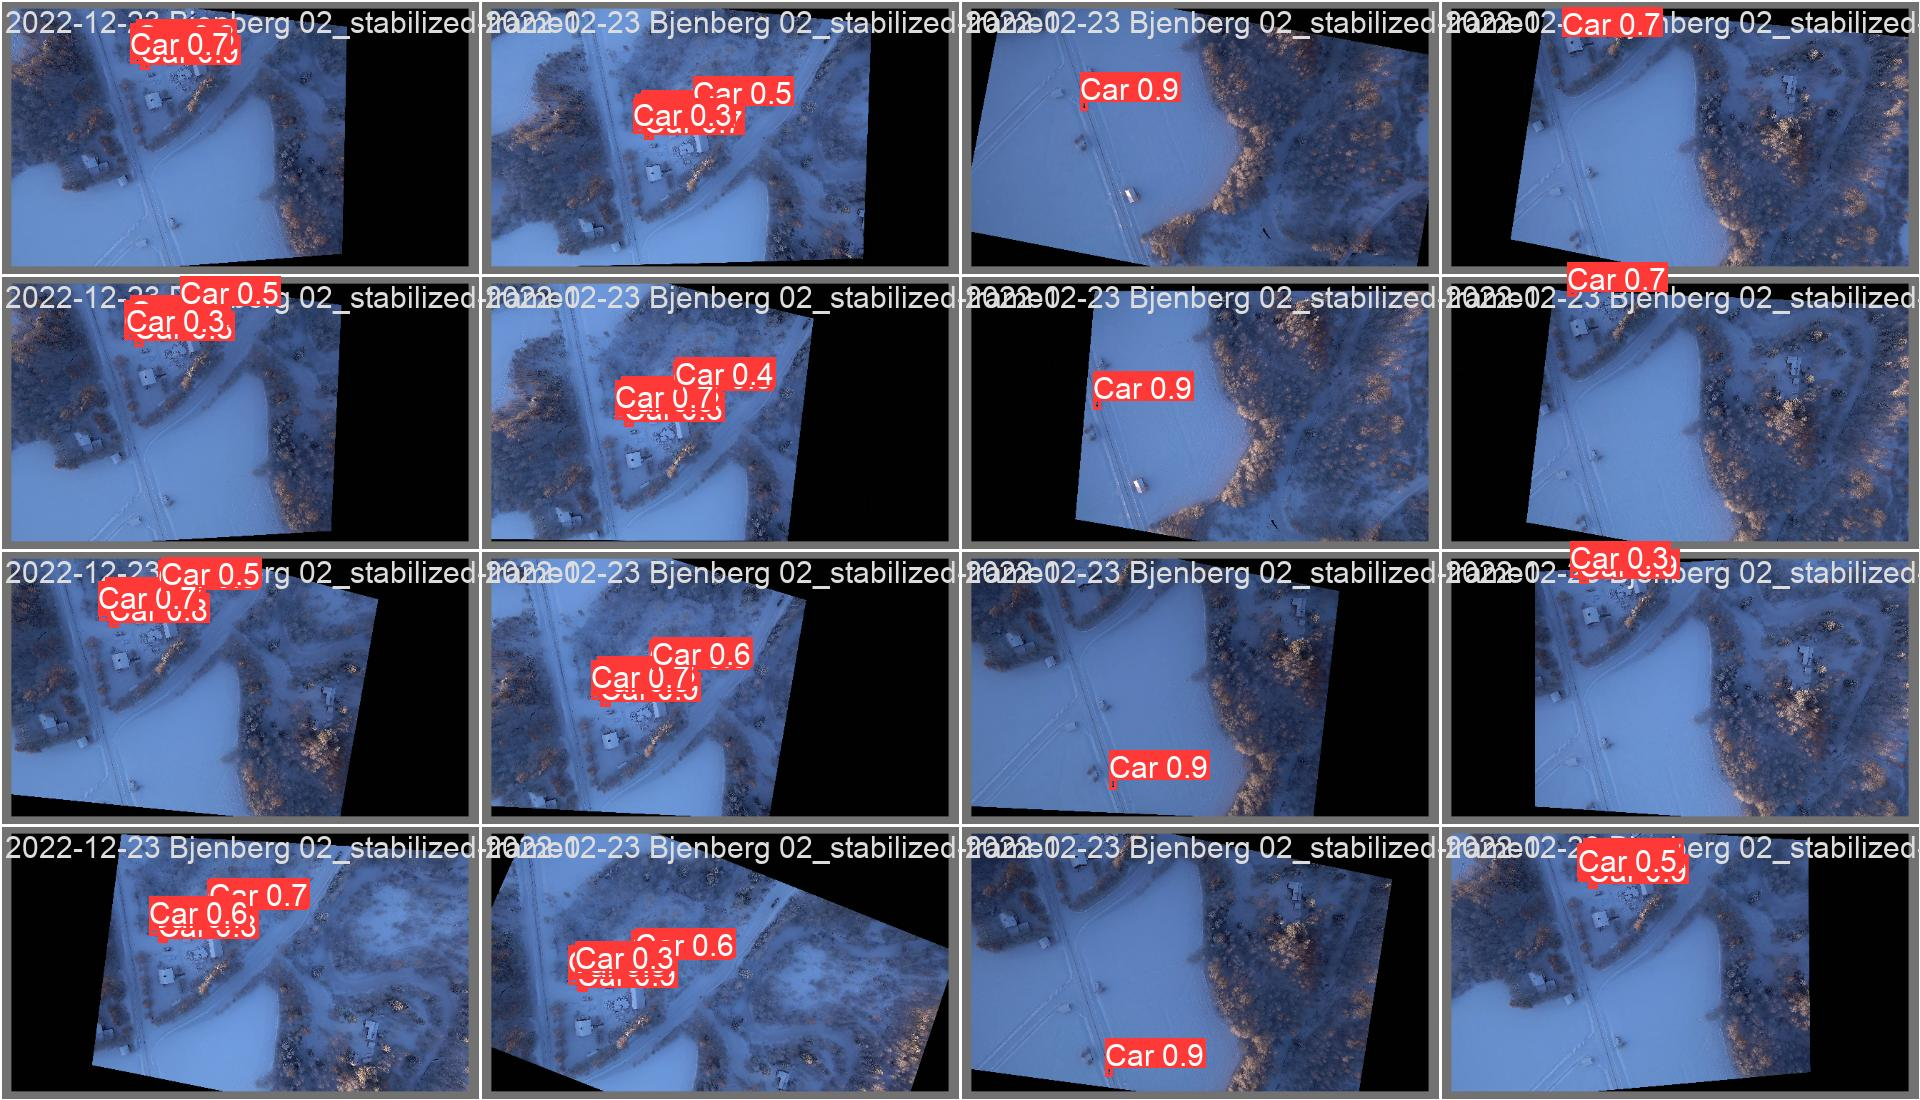

In [10]:
Image(filename=f"runs/detect/val2/val_batch0_pred.jpg")

## Comparison

By comparing the results from the paper with ours, we have observed a huge improvement in performance.

| Model               | Precision | Recall | mAP50  | mAP50-95 |
|---------------------|-----------|--------|--------|----------|
| YOLOv5s             | 54.2%     | 33.7%  | 47.3%  | 30.5%    |
| YOLOv5s_Au*         | 70.6%     | 48.2%  | 56.0%  | 24.1%    |
| YOLOv8s             | 65.8%     | 22.4%  | 45.1%  | 29.8%    |
| YOLOv8s_Au*         | 77.1%     | 34.6%  | 50.7%  | 24.1%    |
| YOLOv9c (our model) | 97.2%     | 94.7%  | 98.3%  | 76.3%      |